# Data Exploration

In [2]:
# !pip install ipyleaflet

# Use these commands in terminal
### Install ipyleaflet:                conda install -c conda-forge ipyleaflet
### Install Node.js:                   conda install -c anaconda nodejs
### Install the JupyterLab extension:  jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-leaflet

# RUN THE FOLLOWING COMMAND IN JUPYTER TERMINAL
# jupyter labextension develop . --overwrite

In [3]:
### Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors

import ipyleaflet as ipy

from pyspark import SparkContext
import pyspark.sql.functions as F
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import *
import pyspark.pandas as ps

import pickle

Matplotlib created a temporary cache directory at /scratch/jtayag/job_30526772/matplotlib-fj11nuc5 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/usr/local/spark/python/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [4]:
### Start Spark context
driver_memory = "24g"
executor_memory = "24g"
n_executors = 16 - 1
try:
    sc = SparkSession.builder.config("spark.driver.memory", driver_memory) \
                             .config("spark.driver.maxResultSize", "5g") \
                             .config("spark.executor.memory", executor_memory) \
                             .config("spark.executor.instances", n_executors) \
                             .getOrCreate()
    print("Initializing SparkContext")
except:
    print("Starting new SparkContext")
    sc.stop()
    sc = SparkSession.builder.config("spark.driver.memory", driver_memory) \
                             .config("spark.driver.maxResultSize", "5g") \
                             .config("spark.executor.memory", executor_memory) \
                             .config("spark.executor.instances", n_executors) \
                             .getOrCreate()
print(sc)

# Start SQL Context
sqlContext = SQLContext(sc)

sc.getActiveSession()

Initializing SparkContext


/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


### Acquiring the data:

To acquire the datasets, you must first create an account on HuggingFace, then request access as the datasets are gated. Once access is granted, there are two options:

1) Download the datasets, then place them in the same directory as this .ipynb file
2) Follow the instructions [here](https://huggingface.co/docs/huggingface_hub/en/quick-start) to access the datasets directly in this notebook



In [5]:
### Load datasets
file_5 = "5min.parquet"
file_30 = "30min.parquet"
meta_filename = "metadata.csv"

df_type = 30
# df_type = 5

### Open parquet files as Spark Data Frame
if df_type == 30:
    df = sqlContext.read.load(file_30).cache()
elif df_type == 5:
    df = sqlContext.read.load(file_5)
df_count = df.count()
df.createOrReplaceTempView("df")

# metadata
df_meta = sc.read.csv(meta_filename, inferSchema=True, header=True)
df_meta_count = df_meta.count()

### Comments
print(f"30min dataset has {df_count} rows")
df.show(3)
print(f"Meta dataset has {df_meta_count} rows")
df_meta.show(3)
print("")
print("Table schemas")
print("")
print("Schema of the 30 min time series data table")
df.printSchema()
print("Schema of the metadata table")
df_meta.printSchema()

### Since metadata table is so small, convert to Pandas
df_meta = df_meta.toPandas()

30min dataset has 2644013376 rows
+-------------+-------------------+-----+
|generation_wh|           datetime|ss_id|
+-------------+-------------------+-----+
|          0.0|2010-11-18 00:00:00| 2405|
|          0.0|2010-11-18 00:30:00| 2405|
|          0.0|2010-11-18 01:00:00| 2405|
+-------------+-------------------+-----+
only showing top 3 rows

Meta dataset has 24662 rows
+-----+----------------+-----------------+---------+-----------+----+----+--------------+
|ss_id|latitude_rounded|longitude_rounded|  llsoacd|orientation|tilt| kwp|operational_at|
+-----+----------------+-----------------+---------+-----------+----+----+--------------+
| 2405|           53.53|            -1.63|E01007430|      180.0|35.0|3.36|    2010-11-18|
| 2406|           54.88|            -1.38|E01008780|      315.0|30.0|1.89|    2010-12-03|
| 2407|           54.88|            -1.38|E01008780|      225.0|30.0|1.89|    2010-12-03|
+-----+----------------+-----------------+---------+-----------+----+----+-----

View summary stats for df_meta
The kwp column appears to have extreme outliers - these will be deleted from the set

              ss_id  latitude_rounded  longitude_rounded   orientation  \
count  24662.000000      24662.000000       24662.000000  24662.000000   
mean   14735.512083         52.978670          -1.408723    178.186238   
std     7119.471183          1.477928           1.389023     47.040838   
min     2405.000000         50.040000          -6.220000      0.000000   
25%     8570.250000         51.890000          -2.350000    150.000000   
50%    14735.500000         52.600000          -1.480000    180.000000   
75%    20900.750000         53.530000          -0.260000    210.000000   
max    27067.000000         58.570000           1.750000    355.000000   

               tilt           kwp  
count  24662.000000  24662.000000  
mean      31.545373      3.017693  
std        6.077633      3.460297  
min        1.000000      0.225000  
25%       30.000000      2.280000  


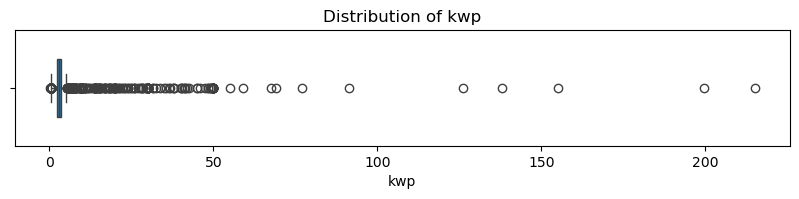


Number of outliers: 11
Outlier IDs listed
[6564, 8712, 10618, 17446, 19064, 23524, 24696, 24865, 24962, 24964, 26721]

Removing IDs with outlier kwp values from df_meta
Number of remaining rows: 24651 (99.955% of original)

CPU times: user 117 ms, sys: 14.6 ms, total: 132 ms
Wall time: 192 ms


In [6]:
%%time
### Preprocessing
print("View summary stats for df_meta")
print("The kwp column appears to have extreme outliers - these will be deleted from the set")
print()
print(df_meta.describe())
print()

### Remove outliers from the metadata
# Locate the upper whisker max: Q3 + 1.5*IQR
Q1, Q3 = df_meta["kwp"].quantile(0.25), df_meta["kwp"].quantile(0.75)
IQR = Q3-Q1
# upper_max = Q3 + 1.5*IQR ################################ Revert to this if keeping some higher kwp values causes issues
upper_max = 50 # Arbitrarily set for now to keep some of the higher kwp values
outliers = df_meta.loc[df_meta["kwp"] > upper_max, :]
outlier_ids = list(outliers["ss_id"])

fig,ax = plt.subplots(1,1, figsize=(10,1.5))
sns.boxplot(x=df_meta["kwp"], orient="h", width=0.5)
plt.title("Distribution of kwp")
plt.show()

print()
print(f"Number of outliers: {len(outliers)}")
print("Outlier IDs listed")
print(outlier_ids)
print()

print("Removing IDs with outlier kwp values from df_meta")
df_meta2 = df_meta.loc[df_meta["kwp"] <= upper_max, :] 
print(f"Number of remaining rows: {len(df_meta2)} ({np.round(100 * len(df_meta2) / df_meta_count, 3)}% of original)")
print()

# Save valid_ids for later use
valid_ids = set(df_meta2["ss_id"])

In [7]:
%%time
### Preprocessing for visualizations
# Add date and time columns for visualizations
# stamp_date: Date as extracted from the timestamp column
# stamp_time_m: Number of minutes from midnight on any given day ----> Separated out for now
# power_kW: Converting generation_wh which is in Watts*(30 min) to kW

# Filter for only remaining rows in df_meta

if df_type == 30:
    conversion = (60/30) * (1/1000)
    df2 = df.where(F.col("ss_id").isin(valid_ids)) \
            .select("generation_wh", "ss_id", F.col("datetime").alias("timestamp")) \
            .withColumn("stamp_date", F.to_date("timestamp")) \
            .withColumn("power_kW", F.col("generation_wh") * F.lit(conversion)) \
            .withColumn("time_i", (F.hour("timestamp") * F.lit(60) + F.minute("timestamp")) / 30) \
            .withColumn("year", F.year("timestamp"))
elif df_type == 5:
    conversion = (60/5) * (1/1000)
    df2 = df.where(F.col("ss_id").isin(valid_ids)) \
            .select("generation_wh", "ss_id", F.col("timestamp").alias("timestamp")) \
            .withColumn("stamp_date", F.to_date("timestamp")) \
            .withColumn("power_kW", F.col("generation_wh") * F.lit(conversion)) \
            .withColumn("time_i", (F.hour("timestamp") * F.lit(60) + F.minute("timestamp")) / 5) \
            .withColumn("year", F.year("timestamp"))

print("Preprocessed 30min dataset")
df2.createOrReplaceTempView("df2")
df2.show(3)

df2_count = df2.count()
print(f"{df2_count} rows remain after preprocessing ({np.round(100 * df2_count/df_count, 6)}% of total rows)")
print()


Preprocessed 30min dataset
+-------------+-----+-------------------+----------+--------+------+----+
|generation_wh|ss_id|          timestamp|stamp_date|power_kW|time_i|year|
+-------------+-----+-------------------+----------+--------+------+----+
|          0.0| 2405|2010-11-18 00:00:00|2010-11-18|     0.0|   0.0|2010|
|          0.0| 2405|2010-11-18 00:30:00|2010-11-18|     0.0|   1.0|2010|
|          0.0| 2405|2010-11-18 01:00:00|2010-11-18|     0.0|   2.0|2010|
+-------------+-----+-------------------+----------+--------+------+----+
only showing top 3 rows

2643067392 rows remain after preprocessing (99.964222% of total rows)

CPU times: user 1.94 s, sys: 481 ms, total: 2.42 s
Wall time: 41.4 s


Find the number of data points in each year bucket

SELECT year, COUNT(*)
FROM df2
GROUP BY year;



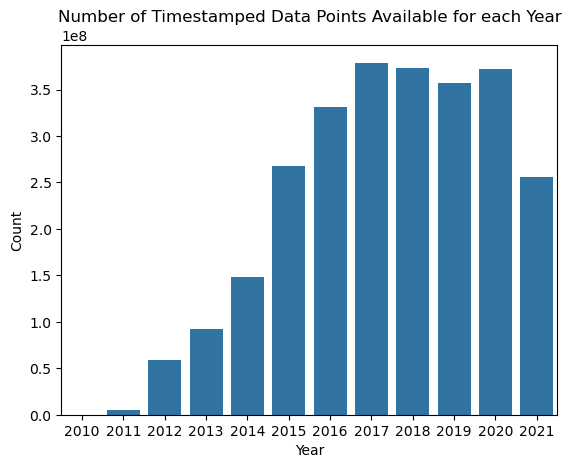

CPU times: user 141 ms, sys: 8.72 ms, total: 150 ms
Wall time: 1min 1s


In [8]:
%%time
### Find the number of data points in each year bucket

# Variables
query_desc = "Find the number of data points in each year bucket"

# Build the query
query = """
SELECT year, COUNT(*)
FROM df2
GROUP BY year;
"""
print(query_desc)
print(query)

year_counts = sqlContext.sql(query).collect()
years = []
counts = []
for i,year_count in enumerate(year_counts):
    years.append(year_counts[i][0])
    counts.append(year_counts[i][1])
    
year_counts2 = pd.DataFrame.from_dict({"Year":years, "Count":counts})

sns.barplot(data=year_counts2, x="Year", y="Count")
plt.title("Number of Timestamped Data Points Available for each Year")
plt.show()

In [9]:
%%time
print("Viewing some stats on the pre-processed 30 min dataset")
variable_bounds = df2.select(F.min("timestamp"), F.max("timestamp"), \
                              F.min("power_kW"), F.max("power_kW"), \
                              F.min("generation_wh"), F.max("generation_wh") \
                             )
variable_bounds.show()

Viewing some stats on the pre-processed 30 min dataset
+-------------------+-------------------+-------------+-------------+------------------+------------------+
|     min(timestamp)|     max(timestamp)|min(power_kW)|max(power_kW)|min(generation_wh)|max(generation_wh)|
+-------------------+-------------------+-------------+-------------+------------------+------------------+
|2010-11-18 00:00:00|2021-09-30 23:30:00|   -1677722.0|     1.514E10|        -8.38861E8|           7.57E12|
+-------------------+-------------------+-------------+-------------+------------------+------------------+

CPU times: user 7.27 ms, sys: 2.04 ms, total: 9.31 ms
Wall time: 45.1 s


In [10]:
%%time
### For data exploration, reduce the dataset to only a week in 2019

# Variables
query_desc = "Reduce the dataset to only values from May in 2019"
timestamp_start = "2019-05-01 00:00:00"
timestamp_end   = "2019-05-30 23:59:59"
show_n_results = 5

# Build the query
query = """
SELECT *
FROM df2
WHERE timestamp BETWEEN '%s' AND '%s';
"""%(timestamp_start, timestamp_end)
print(query_desc)
print(query)
df_2019 = sqlContext.sql(query)
df_2019.createOrReplaceTempView("df_2019")
df_2019.show(show_n_results)


Reduce the dataset to only values from May in 2019

SELECT *
FROM df2
WHERE timestamp BETWEEN '2019-05-01 00:00:00' AND '2019-05-30 23:59:59';

+-------------+-----+-------------------+----------+--------+------+----+
|generation_wh|ss_id|          timestamp|stamp_date|power_kW|time_i|year|
+-------------+-----+-------------------+----------+--------+------+----+
|         NULL| 2607|2019-05-01 00:00:00|2019-05-01|    NULL|   0.0|2019|
|         NULL| 7902|2019-05-01 00:00:00|2019-05-01|    NULL|   0.0|2019|
|         NULL|12451|2019-05-01 00:00:00|2019-05-01|    NULL|   0.0|2019|
|         NULL|12487|2019-05-01 00:00:00|2019-05-01|    NULL|   0.0|2019|
|         NULL|12495|2019-05-01 00:00:00|2019-05-01|    NULL|   0.0|2019|
+-------------+-----+-------------------+----------+--------+------+----+
only showing top 5 rows

CPU times: user 1.48 ms, sys: 2.62 ms, total: 4.11 ms
Wall time: 3.65 s


View data from ids [2607, 2660, 14531] on 2019-05-09

SELECT *
FROM df2
WHERE timestamp BETWEEN '2019-05-09 00:00:00' AND '2019-05-09 23:59:59' AND ss_id IN (2607, 2660, 14531);

+-------------+-----+-------------------+----------+--------+------+----+
|generation_wh|ss_id|          timestamp|stamp_date|power_kW|time_i|year|
+-------------+-----+-------------------+----------+--------+------+----+
|          0.0| 2660|2019-05-09 00:00:00|2019-05-09|     0.0|   0.0|2019|
|          0.0| 2607|2019-05-09 00:00:00|2019-05-09|     0.0|   0.0|2019|
|          0.0|14531|2019-05-09 00:00:00|2019-05-09|     0.0|   0.0|2019|
|          0.0|14531|2019-05-09 00:30:00|2019-05-09|     0.0|   1.0|2019|
|          0.0| 2607|2019-05-09 00:30:00|2019-05-09|     0.0|   1.0|2019|
+-------------+-----+-------------------+----------+--------+------+----+
only showing top 5 rows



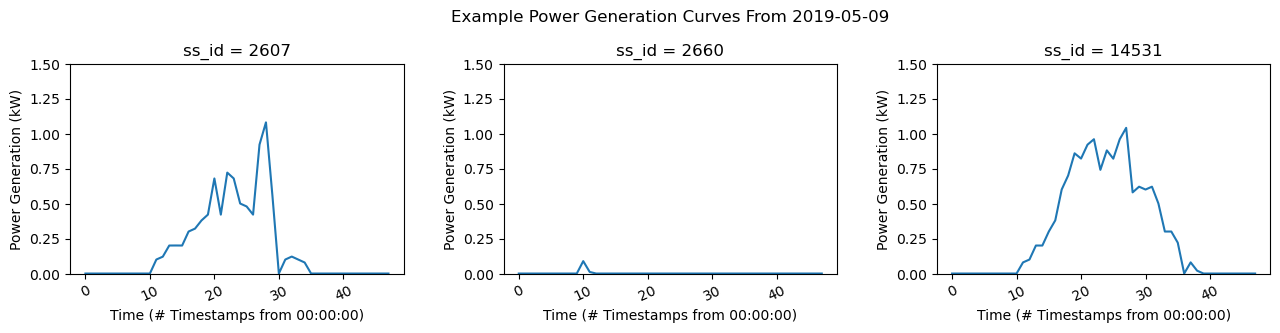

CPU times: user 286 ms, sys: 12.8 ms, total: 299 ms
Wall time: 10.9 s


In [11]:
%%time
# View a plot from a single day
# Variables
ss_ids = [2607, 2660, 14531]
date_val = "2019-05-09"
timestamp_start = f"{date_val} 00:00:00"
timestamp_end = f"{date_val} 23:59:59"
ss_id = "".join(str(ss_ids))[1:-1]
show_n_results = 5

# Build the query
query_desc = f"View data from ids [{ss_id}] on {date_val}"
query = """
SELECT *
FROM df2
WHERE timestamp BETWEEN '%s' AND '%s' AND ss_id IN (%s);
"""%(timestamp_start, timestamp_end, ss_id)

# Run the query
print(query_desc)
print(query)
result = sqlContext.sql(query)
result.show(show_n_results)

# Plot subplots
fig, axes = plt.subplots(1,3, figsize=(15,3))
plt.suptitle(f"Example Power Generation Curves From {date_val}")
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, 
                    top=.8, wspace=0.3,hspace=0.3)
for i,(ss_id,ax) in enumerate(zip(ss_ids, axes.flatten())):
    result_df = result.where(F.col("ss_id") == ss_id).toPandas()
    sns.lineplot(data=result_df, x="time_i", y="power_kW", ax=ax)
    ax.set_title(f"ss_id = {ss_id}")
    ax.set_xlabel("Time (# Timestamps from 00:00:00)")
    ax.set_ylabel("Power Generation (kW)")
    ax.tick_params(axis="x", labelrotation=25)
    # plt.gcf().axes[i].xaxis.set_major_formatter(date_formatter)
    # ax.get_legend().remove()
    ax.set_ylim(0, 1.5)
plt.show()

View data from id 2607, 2660, 14531 from 2019-05-01 to 2019-05-07

SELECT *
FROM df2
WHERE timestamp BETWEEN '2019-05-01 00:00:00' AND '2019-05-07 23:59:59' AND ss_id IN (2607, 2660, 14531);

+-------------+-----+-------------------+----------+--------+------+----+
|generation_wh|ss_id|          timestamp|stamp_date|power_kW|time_i|year|
+-------------+-----+-------------------+----------+--------+------+----+
|         NULL| 2607|2019-05-01 00:00:00|2019-05-01|    NULL|   0.0|2019|
|         NULL|14531|2019-05-01 00:00:00|2019-05-01|    NULL|   0.0|2019|
|         NULL| 2660|2019-05-01 00:00:00|2019-05-01|    NULL|   0.0|2019|
|          0.0|14531|2019-05-01 00:30:00|2019-05-01|     0.0|   1.0|2019|
|          0.0| 2607|2019-05-01 00:30:00|2019-05-01|     0.0|   1.0|2019|
+-------------+-----+-------------------+----------+--------+------+----+
only showing top 5 rows



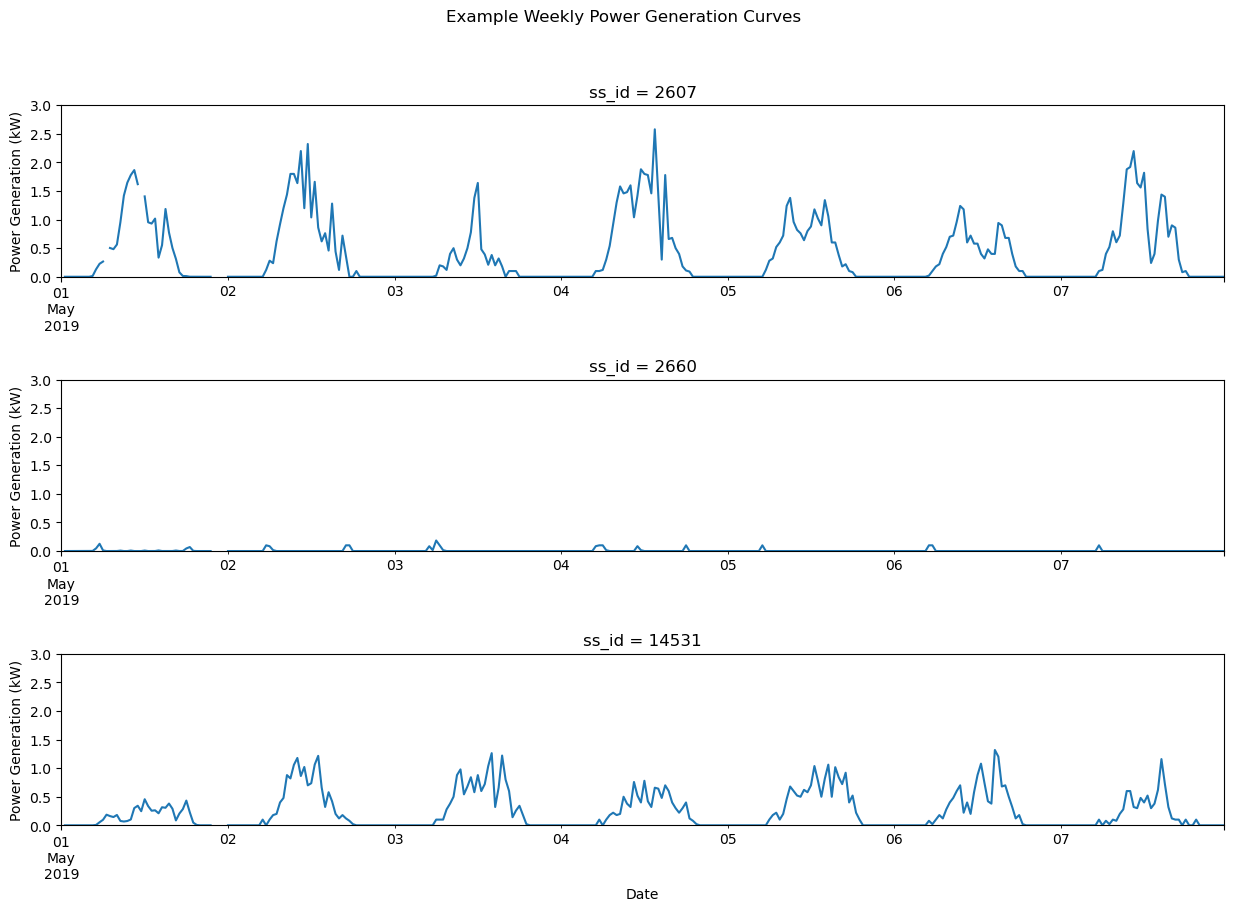

CPU times: user 346 ms, sys: 20.3 ms, total: 366 ms
Wall time: 11.6 s


In [12]:
%%time
# View a plot from a single week
# Variables
ss_ids = [2607, 2660, 14531]
timestamp_start = "2019-05-01 00:00:00"
timestamp_end = "2019-05-07 23:59:59"
ss_id = "".join(str(ss_ids))[1:-1]
show_n_results = 5

# Build the query
query_desc = f"View data from id {ss_id} from 2019-05-01 to 2019-05-07"
query = """
SELECT *
FROM df2
WHERE timestamp BETWEEN '%s' AND '%s' AND ss_id IN (%s);
"""%(timestamp_start, timestamp_end, ss_id)

# Run the query
print(query_desc)
print(query)
result = sqlContext.sql(query)
result.show(show_n_results)

# Plot subplots
fig, axes = plt.subplots(3,1, figsize=(15,12))
plt.suptitle("Example Weekly Power Generation Curves")
plt.subplots_adjust(bottom=0.3, top=0.9, wspace=0.1,hspace=0.6)
for i,(ss_id,ax) in enumerate(zip(ss_ids, axes.flatten())):
    result.where(F.col("ss_id") == ss_id).toPandas().plot(x="timestamp", y="power_kW", ax=ax)
    ax.set_title(f"ss_id = {ss_id}")
    ax.set_ylabel("Power Generation (kW)")
    ax.tick_params(axis="x", labelrotation=0)
    ax.get_legend().remove()
    ax.set_ylim(0, 3)
    if i==2:
        ax.set_xlabel("Date")
    else:
        ax.set_xlabel("")
plt.show()

In [13]:
%%time
### Find the number of null energy values
query_desc = "Find the number of null energy values"
null_counts = df2.agg(F.sum(F.when(F.col("generation_wh").isNull(), 1).otherwise(0)).alias("numNulls_generation"), \
                      F.sum(F.when(F.col("timestamp").isNull(), 1).otherwise(0)).alias("numNulls_timestamp"), \
                      F.sum(F.when(F.col("ss_id").isNull(), 1).otherwise(0)).alias("numNulls_ss_id") \
                     ) 
null_counts.show()
null_counts = null_counts.collect()[0][0]
numNulls_generation = null_counts
print(f"{numNulls_generation} null values in generation_wh ({np.round(100*numNulls_generation/df_count, 6)}% of the total row count)")
print(f"Since there are so relatively few null values, these will be dropped")
print("")

+-------------------+------------------+--------------+
|numNulls_generation|numNulls_timestamp|numNulls_ss_id|
+-------------------+------------------+--------------+
|            1824316|                 0|             0|
+-------------------+------------------+--------------+

1824316 null values in generation_wh (0.068998% of the total row count)
Since there are so relatively few null values, these will be dropped

CPU times: user 10.3 ms, sys: 7.31 ms, total: 17.6 ms
Wall time: 1min 21s


In [14]:
%%time
### Find the number of date/ID pairings without all timestamps and/or with NULL values
if df_type == 30:
    max_timestamps = 24*60/30
elif df_type == 5:
    max_timestamps = 24*60/5
    
query_desc = "Count the total number of date/id groupings in this dataset without complete data"
query = """
SELECT ss_id AS incomplete_ss_id, stamp_date AS incomplete_stamp_date
FROM df2
WHERE generation_wh IS NOT NULL
GROUP BY ss_id, stamp_date
HAVING COUNT(*) < %s
"""%(max_timestamps)

print(query_desc)
print(query)
incomplete_data = sqlContext.sql(query).toPandas()
print("query complete")
incomplete_data.to_csv("incomplete_data.csv", header=True, index=False)

count_dates_withoutAllTimestamps = len(incomplete_data)
print(f"{count_dates_withoutAllTimestamps} date/ID groupings without all {max_timestamps} timestamps ({np.round(100 * count_dates_withoutAllTimestamps/df_count, 3)}% of all date/ID groupings)")
print("Since this fraction is relatively low, these will be filtered out to ensure analysis is only on data with all 48 timestamps")
print("")

Count the total number of date/id groupings in this dataset without complete data

SELECT ss_id AS incomplete_ss_id, stamp_date AS incomplete_stamp_date
FROM df2
WHERE generation_wh IS NOT NULL
GROUP BY ss_id, stamp_date
HAVING COUNT(*) < 48.0

query complete
144730 date/ID groupings without all 48.0 timestamps (0.005% of all date/ID groupings)
Since this fraction is relatively low, these will be filtered out to ensure analysis is only on data with all 48 timestamps

CPU times: user 1.05 s, sys: 37.4 ms, total: 1.09 s
Wall time: 3min 13s


In [15]:
incomplete_data = pd.read_csv("incomplete_data.csv")
incomplete_data.reset_index(inplace=True)

incomplete_data.head(3)

,index,incomplete_ss_id,incomplete_stamp_date
0,0,3021,2011-11-07
1,1,3094,2011-11-10
2,2,2827,2011-11-11


In [16]:
%%time
### Final preprocessing
# Collect the timestamp values into a list for each date/ID pairing

incomplete_data = pd.read_csv("incomplete_data.csv")
incomplete_ss_id = list(incomplete_data["incomplete_ss_id"])
incomplete_date = list(incomplete_data["incomplete_stamp_date"])

if df_type == 30:
    max_timestamps = 24*60/30
    conversion = (60/30) * (1/1000)
    df2 = df.where(F.col("ss_id").isin(valid_ids)) \
            .select("generation_wh", "ss_id", F.col("datetime").alias("timestamp")) \
            .withColumn("stamp_date", F.to_date("timestamp")) \
            .where(~((F.col("ss_id").isin(incomplete_ss_id)) & (F.col("stamp_date").isin(incomplete_date)))) \
            .withColumn("time_i", (F.hour("timestamp") * F.lit(60) + F.minute("timestamp")) / 30) \
            .withColumn("power_kW", F.col("generation_wh") * F.lit(conversion))
elif df_type == 5:
    max_timestamps = 24*60/5
    conversion = (60/5) * (1/1000)
    df2 = df.where(F.col("ss_id").isin(valid_ids)) \
            .select("generation_wh", "ss_id", F.col("timestamp").alias("timestamp")) \
            .withColumn("stamp_date", F.to_date("timestamp")) \
            .where(~((F.col("ss_id").isin(incomplete_ss_id)) & (F.col("stamp_date").isin(incomplete_date)))) \
            .withColumn("time_i", (F.hour("timestamp") * F.lit(60) + F.minute("timestamp")) / 5) \
            .withColumn("power_kW", F.col("generation_wh") * F.lit(conversion))

df2_count = df2.count()
print(f"{df2_count} rows remain after preprocessing ({np.round(100 * df2_count/df_count, 6)}% of total rows)")
print("")


2399619984 rows remain after preprocessing (90.756726% of total rows)

CPU times: user 26.3 s, sys: 6.55 s, total: 32.9 s
Wall time: 3min 17s


In [17]:
%%time
### Filter for metadata rows on ss_ids that are in df2
query_desc = "Filter for metadata rows on ss_ids that are in df"

query = """
SELECT ss_id
FROM df2;
"""

print(query_desc)
print(query)
distinct_ss_ids = df2.agg(F.collect_set("ss_id")).collect()[0][0]
df_meta3 = df_meta2[df_meta2["ss_id"].isin(distinct_ss_ids)]
df_meta_count3 = len(df_meta3)

print(f"Number of rows in df_meta: {df_meta_count}")
print(f"Number of rows in filtered df_meta: {df_meta_count3} ({np.round(100 * df_meta_count3/df_meta_count, 6)}% of total rows)")
print("")

Filter for metadata rows on ss_ids that are in df

SELECT ss_id
FROM df2;

Number of rows in df_meta: 24662
Number of rows in filtered df_meta: 24299 (98.5281% of total rows)

CPU times: user 19 ms, sys: 5.59 ms, total: 24.6 ms
Wall time: 1min 40s


In [18]:
### View summary stats on the remaining IDs
df_meta3.to_csv("metadata_preprocessed.csv", header=True, index=False)
df_meta3 = pd.read_csv("metadata_preprocessed.csv")
print("View summary stats on preprocessed df_meta")
df_meta3.info()
df_meta3.describe()

View summary stats on preprocessed df_meta
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24299 entries, 0 to 24298
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ss_id              24299 non-null  int64  
 1   latitude_rounded   24299 non-null  float64
 2   longitude_rounded  24299 non-null  float64
 3   llsoacd            24299 non-null  object 
 4   orientation        24299 non-null  float64
 5   tilt               24299 non-null  float64
 6   kwp                24299 non-null  float64
 7   operational_at     24281 non-null  object 
dtypes: float64(5), int64(1), object(2)
memory usage: 1.5+ MB


,ss_id,latitude_rounded,longitude_rounded,orientation,tilt,kwp
count,24299.000000,24299.000000,24299.000000,24299.000000,24299.000000,24299.000000
mean,14591.825960,52.989486,-1.401896,178.082843,31.507758,2.967349
std,7028.149292,1.476230,1.388700,47.110187,6.045058,2.285005
min,2405.000000,50.040000,-6.220000,0.000000,1.000000,0.225000
25%,8512.500000,51.900000,-2.330000,150.000000,30.000000,2.280000
50%,14597.000000,52.600000,-1.480000,180.000000,30.000000,2.800000
75%,20676.500000,53.530000,-0.260000,210.000000,35.000000,3.420000
max,26770.000000,58.570000,1.750000,355.000000,65.000000,50.000000


In [19]:
%%time
# Set up necessary variables
map_df_meta = df_meta3.sample(frac=0.25)
columns = ["latitude_rounded", "longitude_rounded", "orientation", "tilt", "kwp"]
min_values = map_df_meta[columns].min()
max_values = map_df_meta[columns].max()

print("Min values")
print(min_values)
print()
print("Max values")
print(max_values)

min_lat, min_long, min_orient, min_tilt, min_kwp = min_values
max_lat, max_long, max_orient, max_tilt, max_kwp = max_values
print()

Min values
latitude_rounded     50.10
longitude_rounded    -5.61
orientation           1.00
tilt                  1.00
kwp                   0.50
dtype: float64

Max values
latitude_rounded      58.53
longitude_rounded      1.72
orientation          355.00
tilt                  63.00
kwp                   50.00
dtype: float64

CPU times: user 3.45 ms, sys: 0 ns, total: 3.45 ms
Wall time: 3.32 ms


In [32]:
# %%time
### Plot ONLY filtered stations on the map

# Map Vars
map_center = [np.mean([min_lat, max_lat]), np.mean([min_long, max_long])]
zoom = 5

m = ipy.Map( \
           basemap= ipy.basemaps.OpenStreetMap.Mapnik, \
           default_tiles= ipy.TileLayer(opacity=1.0), \
           center=map_center, \
           zoom=zoom \
          )
# m.layout.width = "900px"
# m.layout.height = "900px"

# Plot each system as a circle where the color indicates presence in dataset
color = "blue"
circles = []


for i,row in map_df_meta.iterrows():
    latitude = row["latitude_rounded"]
    longitude = row["longitude_rounded"]
    
    c = ipy.Circle(location=(latitude, longitude), \
                  color = color, \
                  opacity = 0.1, \
                  fill_opacity = 0.1,\
                  fill_color = color \
                  )
    m += c
    
m

Map(center=[54.315, -1.9450000000000003], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_…

Plotting Stations Colored by Power Generation Rating (kwp)



Map(center=[54.315, -1.9450000000000003], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_…

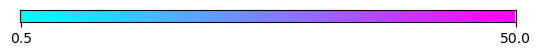

In [33]:
#%%time
print("Plotting Stations Colored by Power Generation Rating (kwp)")
print()
### Plot stations according to kwp
m = ipy.Map( \
           basemap= ipy.basemaps.OpenStreetMap.Mapnik, \
           default_tiles= ipy.TileLayer(opacity=1.0), \
           center=map_center, \
           zoom=zoom \
          )

# Plot each system as a circle where the color indicates presence in dataset
# Color represents another value

color_col = "kwp"
min_values = min_kwp
max_values = max_kwp

colorbar_base = matplotlib.cm.cool(np.arange(0,1,0.005))[:, :3]
colorbar_shaped = np.stack([colorbar_base]*5)
xticks_scaled = (colorbar_shaped.shape[1] - min_values) / (max_values - min_values)

plt.imshow(colorbar_shaped)
plt.yticks(())
plt.xticks((0, colorbar_shaped.shape[1]), [min_values, max_values])

circles = []

for i,row in map_df_meta.sort_values(by="kwp", ascending=True).iterrows():
    latitude = row["latitude_rounded"]
    longitude = row["longitude_rounded"]
    value = row[color_col]
    scaled_value = (value - min_values) / (max_values - min_values)
    color = matplotlib.colors.rgb2hex(matplotlib.cm.cool(scaled_value))
    if value > 5:
        opacity = 1
        fill_color = 1
    else:
        opacity = 0.2
        fill_color = 0.2
    
    c = ipy.Circle(location=(latitude, longitude), \
                  color = color, \
                  opacity = 0.2, \
                  fill_opacity = 0.2,\
                  fill_color = color \
                  )
    m += c
    
m

Plotting Stations Colored by Orientation



Map(center=[54.315, -1.9450000000000003], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_…

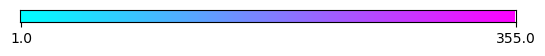

In [36]:
#%%time
print("Plotting Stations Colored by Orientation")
print()
### Plot stations according to orientation
m = ipy.Map( \
           basemap= ipy.basemaps.OpenStreetMap.Mapnik, \
           default_tiles= ipy.TileLayer(opacity=1.0), \
           center=map_center, \
           zoom=zoom \
          )

# Plot each system as a circle where the color indicates presence in dataset
# Color represents another value
color_col = "orientation"
min_values = min_orient
max_values = max_orient

colorbar_base = matplotlib.cm.cool(np.arange(0,1,0.005))[:, :3]
colorbar_shaped = np.stack([colorbar_base]*5)
xticks_scaled = (colorbar_shaped.shape[1] - min_values) / (max_values - min_values)

plt.imshow(colorbar_shaped)
plt.yticks(())
plt.xticks((0, colorbar_shaped.shape[1]), [min_values, max_values])

circles = []

for i,row in map_df_meta.iterrows():
    latitude = row["latitude_rounded"]
    longitude = row["longitude_rounded"]
    value = row[color_col]
    scaled_value = (value - min_values) / (max_values - min_values)
    color = matplotlib.colors.rgb2hex(matplotlib.cm.cool(scaled_value))
    
    c = ipy.Circle(location=(latitude, longitude), \
                  color = color, \
                  opacity = 0.2, \
                  fill_opacity = 0.2,\
                  fill_color = color \
                  )
    m += c
    
m

Plotting Stations Colored by Tilt



Map(center=[54.315, -1.9450000000000003], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_…

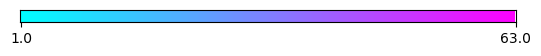

In [37]:
#%%time
print("Plotting Stations Colored by Tilt")
print()
### Plot stations according to tilt
m = ipy.Map( \
           basemap= ipy.basemaps.OpenStreetMap.Mapnik, \
           default_tiles= ipy.TileLayer(opacity=1.0), \
           center=map_center, \
           zoom=zoom \
          )

# Plot each system as a circle where the color indicates presence in dataset
# Color represents another value
color_col = "tilt"
min_values = min_tilt
max_values = max_tilt

colorbar_base = matplotlib.cm.cool(np.arange(0,1,0.005))[:, :3]
colorbar_shaped = np.stack([colorbar_base]*5)
xticks_scaled = (colorbar_shaped.shape[1] - min_values) / (max_values - min_values)

plt.imshow(colorbar_shaped)
plt.yticks(())
plt.xticks((0, colorbar_shaped.shape[1]), [min_values, max_values])

circles = []

for i,row in map_df_meta.iterrows():
    latitude = row["latitude_rounded"]
    longitude = row["longitude_rounded"]
    value = row[color_col]
    scaled_value = (value - min_values) / (max_values - min_values)
    color = matplotlib.colors.rgb2hex(matplotlib.cm.cool(scaled_value))
    
    c = ipy.Circle(location=(latitude, longitude), \
                  color = color, \
                  opacity = 0.2, \
                  fill_opacity = 0.2,\
                  fill_color = color \
                  )
    m += c
    
m

In [24]:
### Save the datasets

# df2.rdd.saveAsPickleFile("df_pickled")
df_meta3.to_csv("metadata_preprocessed.csv", header=True, index=False)